# Bayesian copula estimation: Describing correlated joint distributions

## The problem
複数の変数 ($a$ と $b$ など) を扱うとき、同時分布 $P(a, b)$ をパラメトリックに記述したいことがよくあります。 運が良ければ、この共同配布はある意味「単純」になるかもしれません。
たとえば、$a$ と $b$ が統計的に独立している可能性があります。その場合、結合分布を $P(a, b) = P(a)P(b)$ に分解できます。 $P(a)$ と $P(b)$ の適切なパラメータ記述を見つける必要があります。
これが適切ではないとしても、$P(a, b)$ は、たとえば多変量正規分布などの単純な多変量分布によって適切に記述できる可能性があります。

ただし、実際のデータセットを扱う場合、$P(a, b)$ には複雑な相関構造が存在することがよくあります。これは、これら 2 つの以前のアプローチが利用できないことを意味します。
したがって、代替方法が必要になります。

## Copulas to the rescue
ここで [copulas](https://en.wikipedia.org/wiki/Copula_(probability_theory)) の出番です。これらを使用すると、単純な多変量分布 (多変量ガウスなど)、2 つの周辺分布、およびいくつかの変換による相関構造を持つ複雑な分布 $P(a, b)$ を記述することができます。 。
コピュラの非常にわかりやすい入門については、Thomas Wiecki による [このブログ投稿](https://twiecki.io/blog/2018/05/03/copulas/) を一読することをお勧めします。

このノートブックでは、ベイジアン法を使用してコピュラのパラメータを推論し、相関構造を持つ分布 $P(a, b)$ を記述する方法を説明します。
ここで採用する一般的なアプローチを以下の図に示します。

* 下部には、データが存在する **観察スペース** があります。
* このデータは上から下までのプロセスを通じて生成されたと想定できます。**多変量正規空間** には多変量正規分布があり、これが 2 段階で変換されて、観測空間でのデータが得られます。
* **観測空間**のデータにアクセスできますが、一方から他方に変換することで**多変量正規空間**のパラメータについて推論することができます。

![Alt text](https://www.pymc.io/projects/examples/en/latest/_images/copula_schematic.png "Copulas to the rescue")

2D ガウス コピュラの概略図。 観測空間 (下) の複素分布 $P(a, b)$ は、多変量正規空間 (上) の 2D ガウス コピュラによって生成されるようにモデル化されています。 多変量正規空間から観測空間（下向き）へのマッピングは、正規累積密度関数によって行われ、次に周辺分布の逆累積密度関数によって行われます。 逆の推論プロセス (上向き) は、周辺分布の累積密度関数とそれに続く正規分布の逆累積密度関数によって実行できます。

このノートブックでは、豊富な相関構造を持つ二変量データに基づいてコピュラについて推論を行う方法について説明します。
私たち [PyMC Labs](https://www.pymc-labs.com/) は、[Gates Foundation](https://www.gatesfoundation.org/) との大規模プロジェクトの一環としてこの作業を完了しました。その一部については、[こちら](https://www.pymc.io/projects/examples/en/latest/case_studies/binning.html#binning) でも概説されています。

![Alt text](https://www.pymc.io/projects/examples/en/latest/_images/gates_labs_logos1.png "Copulas to the rescue")

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from scipy.stats import expon, multivariate_normal, norm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
plt.rcParams.update({"font.size": 14, "figure.constrained_layout.use": False})
SEED = 43
rng = np.random.default_rng(SEED)

## Data generating process
推論に入る前に、時間をかけて上の概略図のステップを具体化していきます。
まず、多変量法線コピュラを記述して生成モデルを実証し、それを観測空間に変換します。 次に、逆変換によって観測空間から多変量正規空間に戻ることがどのように可能になるかを示します。
これらの詳細を確認したら、後のセクションの推論プロセスに進みます。

ここで、ネストされた辞書を使用してガウス コピュラのプロパティを定義します。 最上位には、キー ```a```、```b```、および ```rho``` があります。

* ```rho``` は多変量正規コピュラの相関係数を記述します。
* ```a``` と ```b``` も辞書であり、それぞれには周辺分布 (scipy 分布オブジェクトとして) とそのパラメータが含まれています。

ゼロ平均と単位分散を持つ多変量正規分布を暗黙的に定義していることに注意してください。
これは、これらの瞬間が、上記のコピュラ図の 2 番目のステップである「均一空間」による変換を生き残れないためです。

In [3]:
# define properties of our copula
b_scale = 2
θ = {"a_dist": norm(), "b_dist": expon(scale=1 / b_scale), "rho": 0.9}

まず、真の多変量正規分布を定義し、そこからいくつかのサンプルを抽出します。

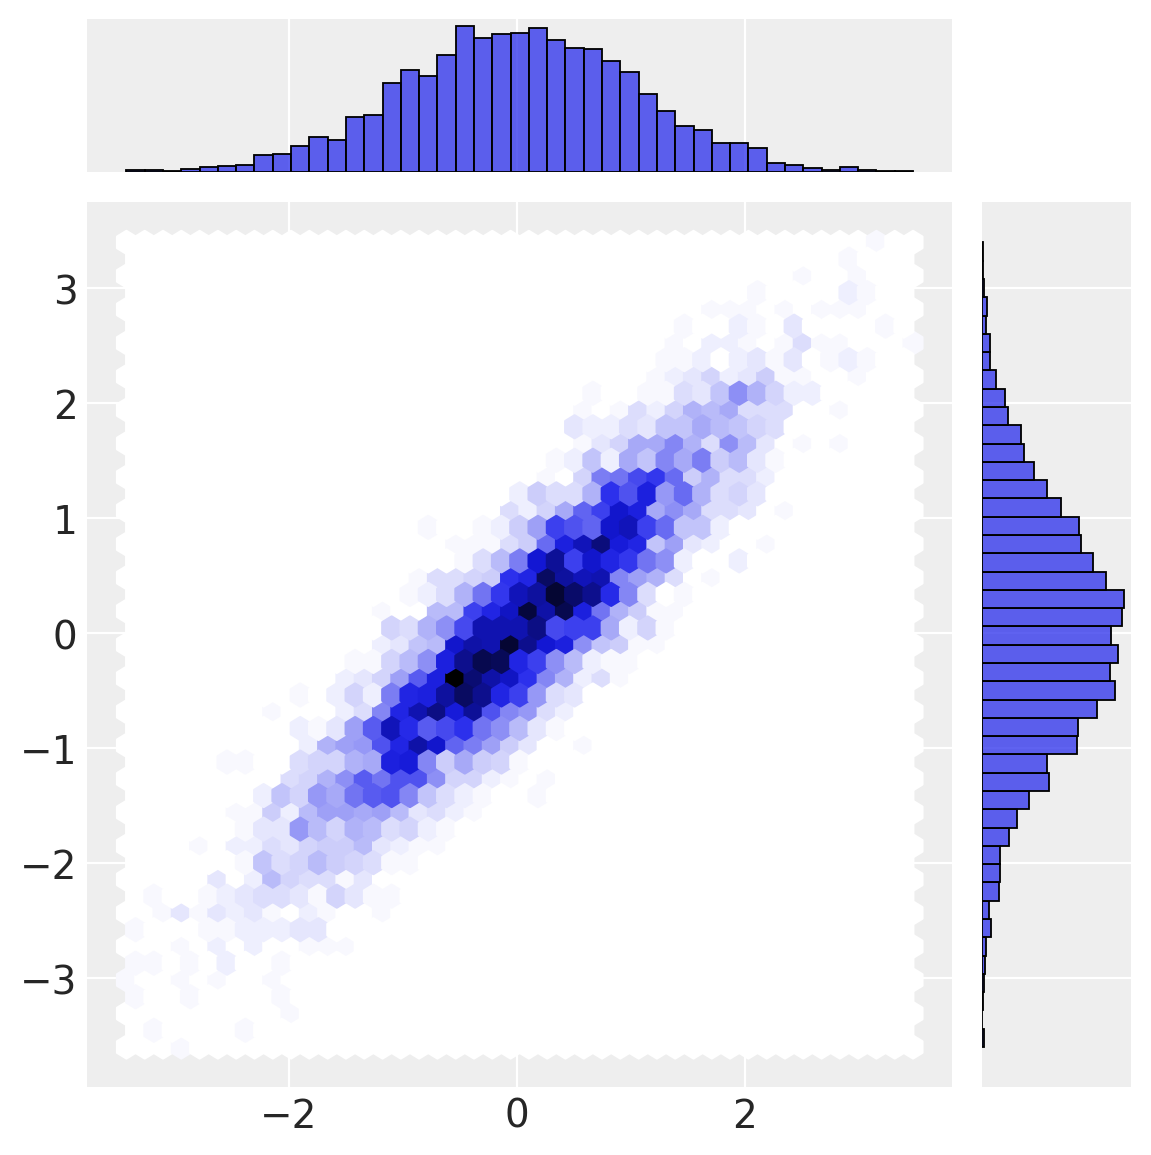

In [4]:
n_samples = 5000

# draw random samples in multivariate normal space
mu = [0, 0]
cov = [[1, θ["rho"]], [θ["rho"], 1]]
x = multivariate_normal(mu, cov).rvs(n_samples, random_state=rng)
a_norm = x[:, 0]
b_norm = x[:, 1]

sns.jointplot(x=a_norm, y=b_norm, height=6, kind="hex");

最初の変換 (正規 cdf) は、データを多変量正規空間から一様空間に変換します。
周辺分布は均一ですが、多変量正規空間からの相関構造が以下の興味深い結合密度に残っていることに注目してください。

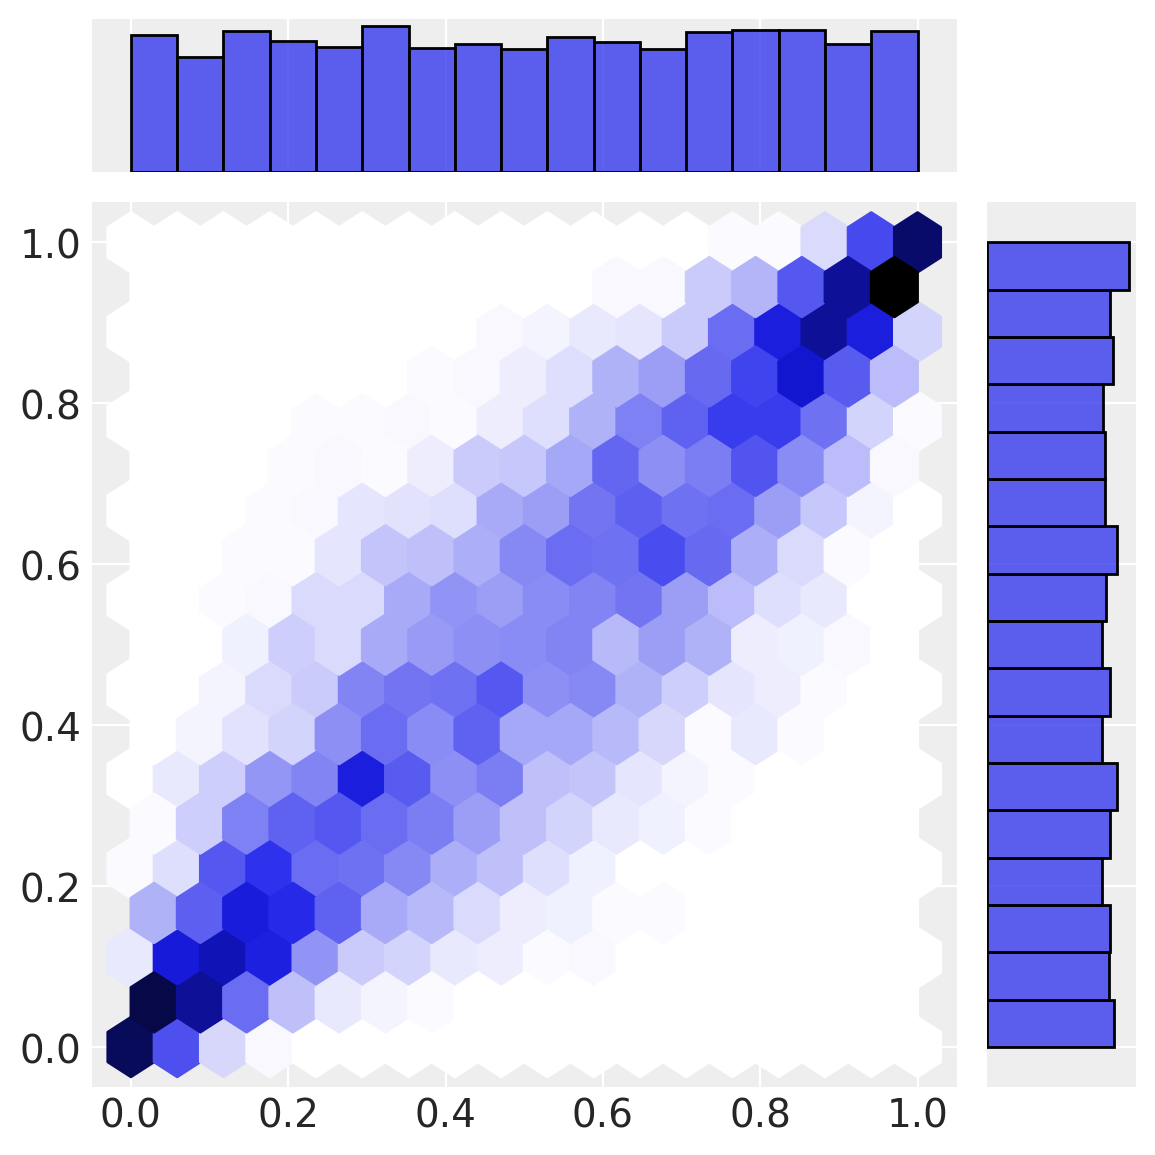

In [5]:
# make marginals uniform
a_unif = norm(loc=0, scale=1).cdf(a_norm)
b_unif = norm(loc=0, scale=1).cdf(b_norm)
sns.jointplot(x=a_unif, y=b_unif, height=6, kind="hex");

最後の変換 (周辺分布の逆 CDF) により、観測空間に $a$ と $b$ が生じます。

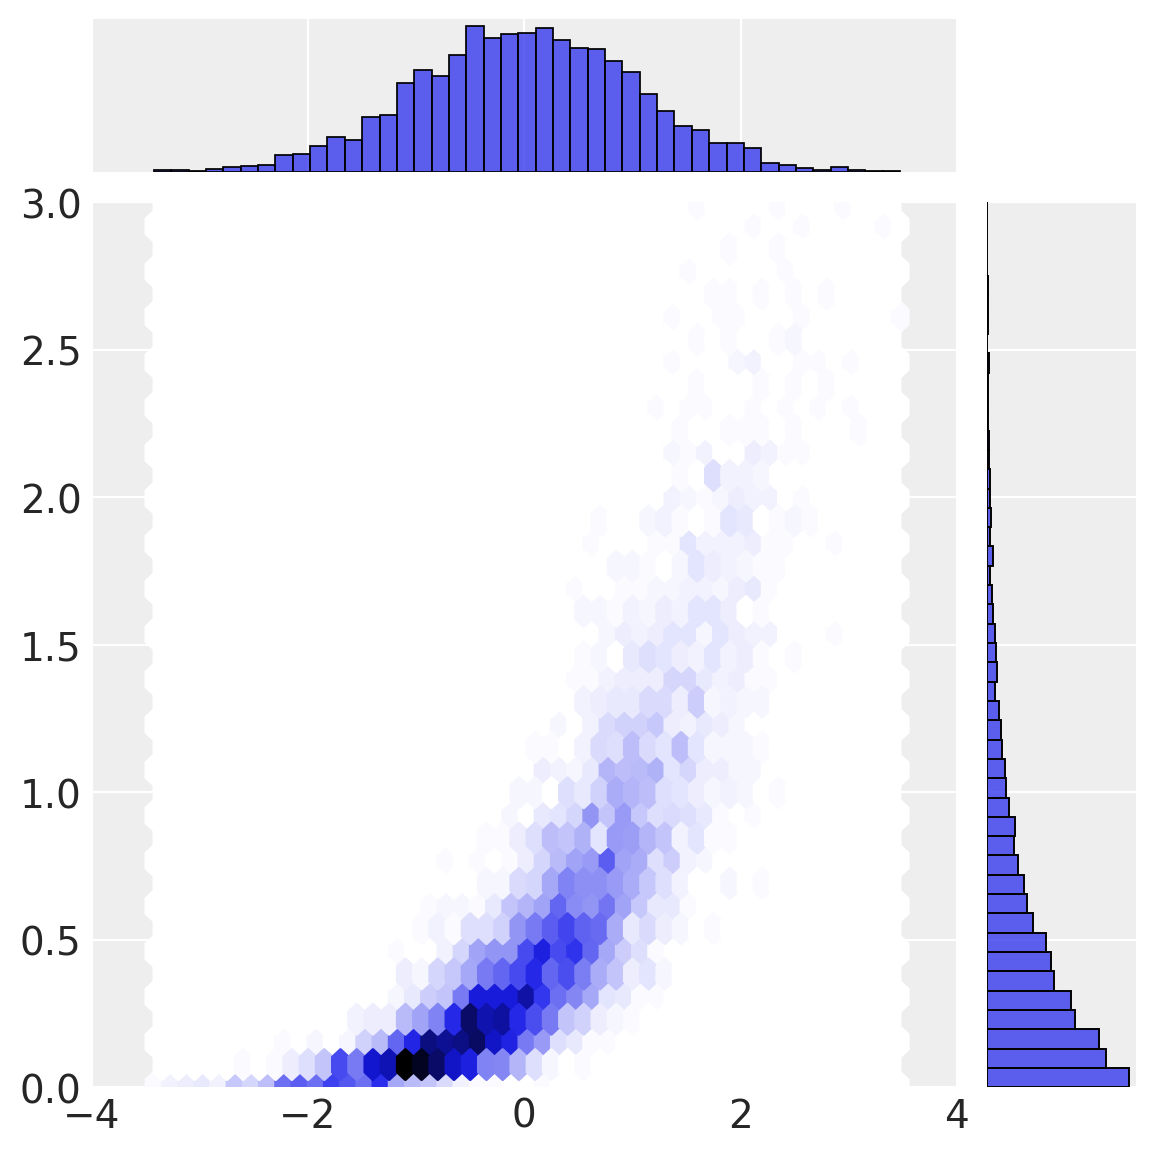

In [6]:
# transform to observation space
a = θ["a_dist"].ppf(a_unif)
b = θ["b_dist"].ppf(b_unif)
sns.jointplot(x=a, y=b, height=6, kind="hex", xlim=(-4, 4), ylim=(0, 3));

## Copula inference process
採用されたアプローチを理解するために、観測空間から多変量正規空間へ向かう逆のプロセスをたどります。

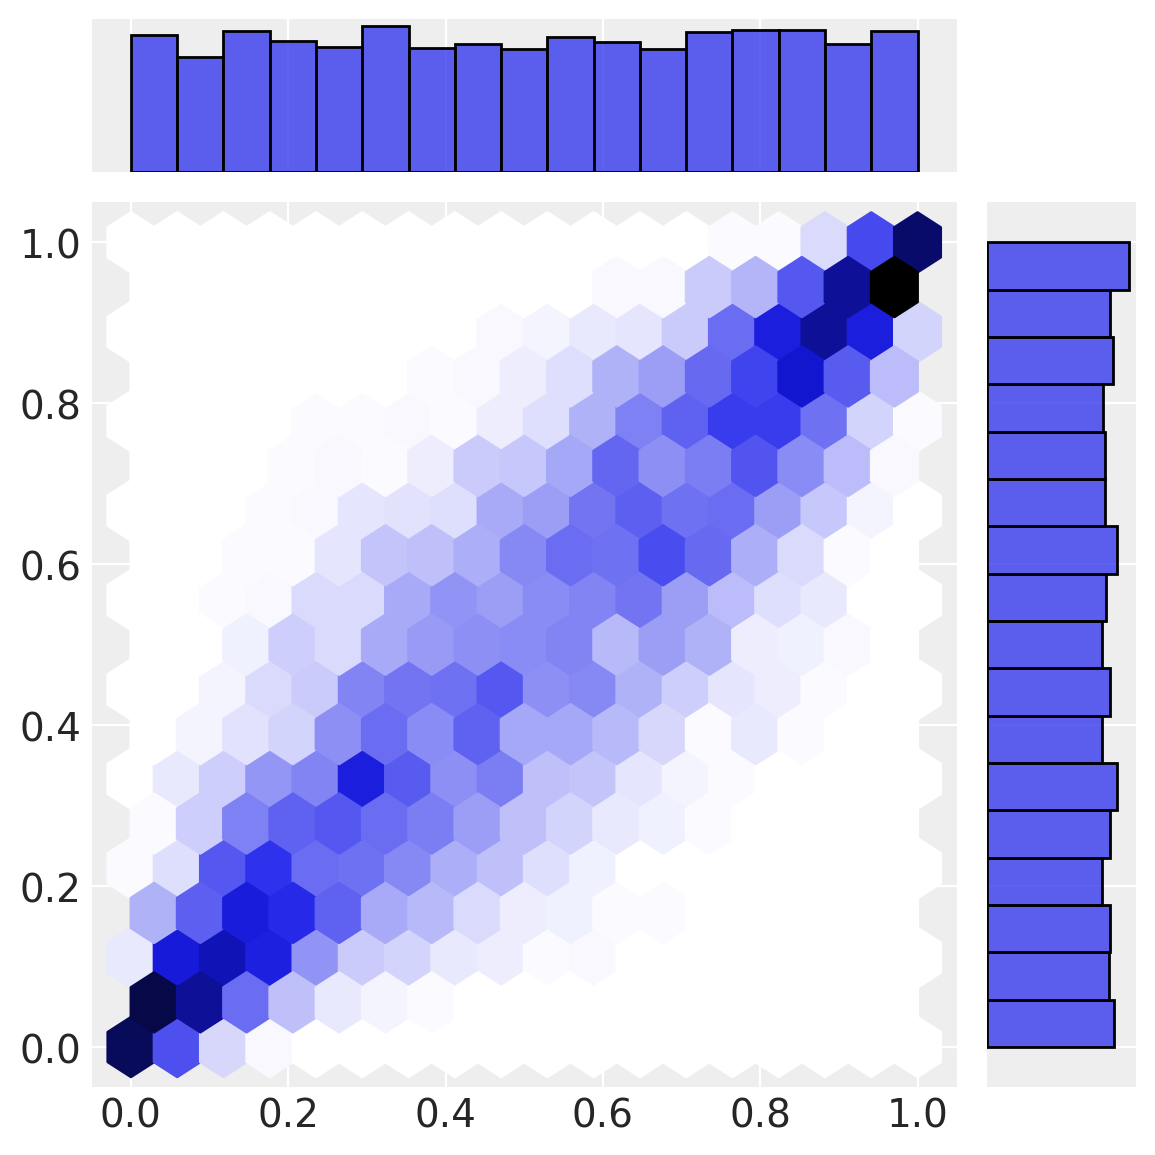

In [7]:
# observation -> uniform space
a1 = θ["a_dist"].cdf(a)
b1 = θ["b_dist"].cdf(b)
sns.jointplot(x=a1, y=b1, kind="hex", height=6);

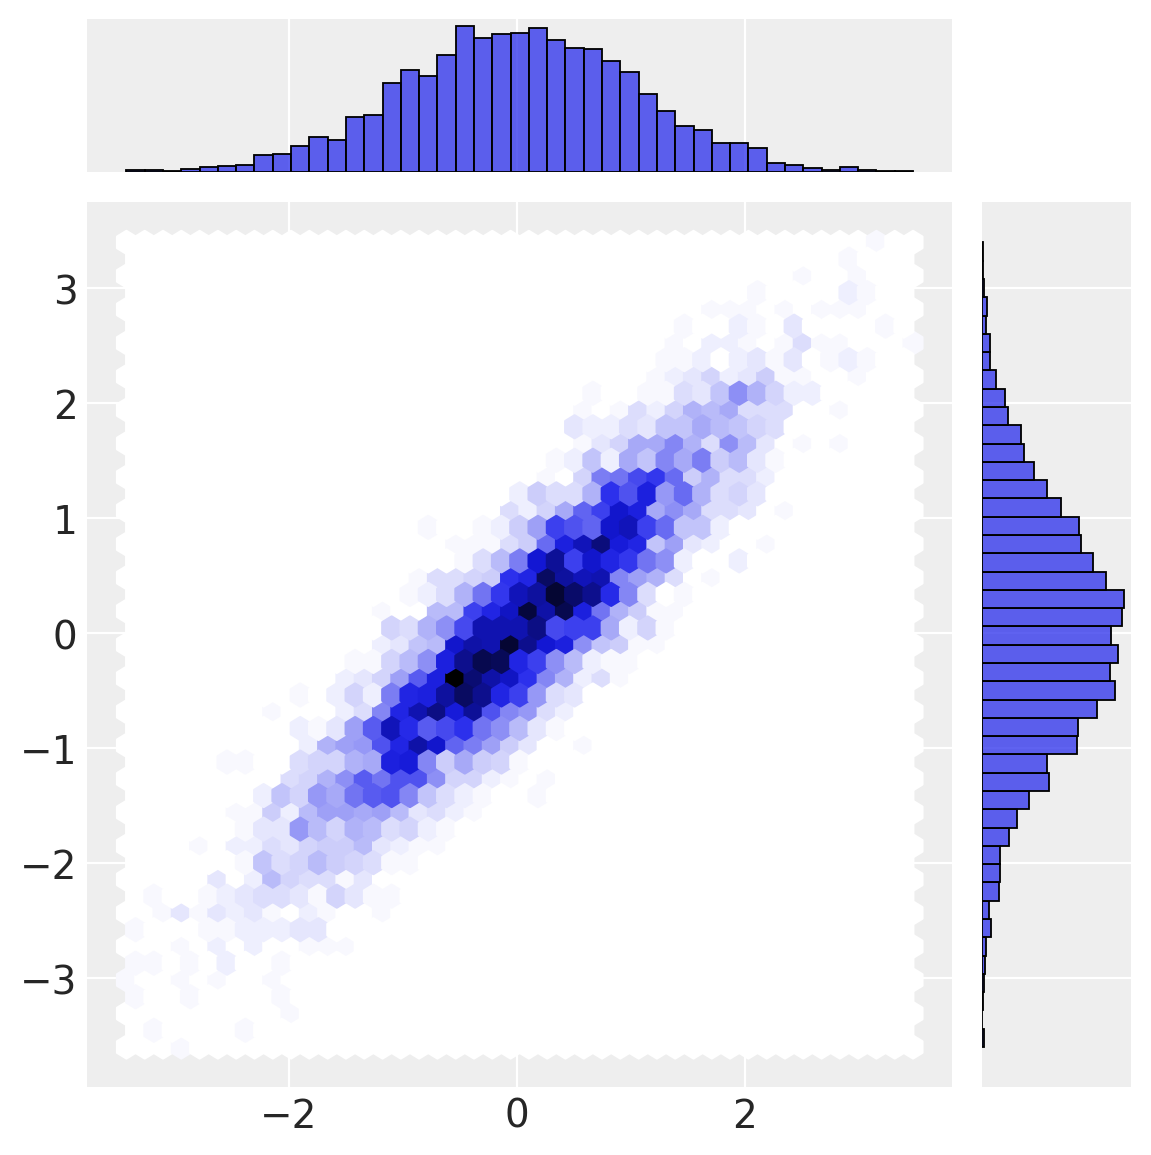

In [8]:
# uniform -> MvNormal space
a2 = norm(loc=0, scale=1).ppf(a1)
b2 = norm(loc=0, scale=1).ppf(b1)
sns.jointplot(x=a2, y=b2, kind="hex", height=6);

これで、図 1 で概要を説明した内容を完了しました。多変量法線から観測空間に至るデータ生成プロセスを詳細に説明しました。 次に、観測空間から多変量正規空間への逆 (推論) プロセスを実行する方法を確認しました。 これは、PyMC モデルで使用するアプローチです。

## PyMC models for copula and marginal estimation
観測空間のデータによってもっともらしいパラメータ値を制約しながら、多変量正規空間でパラメータに関する推論を実行します。
ただし、$a$ と $b$ の観測結果を使用して、周辺分布のパラメーターの推定値を制限します。

私たちの実験では、周縁のパラメータとコピュラの共分散パラメータを同時に推定するモデルを検討しましたが、これが不安定であることがわかりました。 以下で使用したソリューションはより堅牢であることが判明しており、2 段階のプロセスが必要です。

1. 周辺分布のパラメーターを推定します。
1. ステップ 1 の周辺分布パラメーターの点推定を使用して、コピュラの共分散パラメーターを推定します。

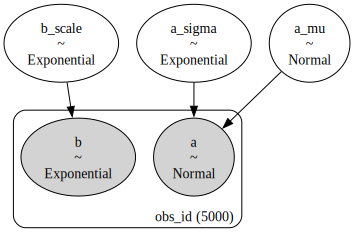

In [9]:
coords = {"obs_id": np.arange(len(a))}
with pm.Model(coords=coords) as marginal_model:
    """
    Assumes observed data in variables `a` and `b`
    """
    # marginal estimation
    a_mu = pm.Normal("a_mu", mu=0, sigma=1)
    a_sigma = pm.Exponential("a_sigma", lam=0.5)
    pm.Normal("a", mu=a_mu, sigma=a_sigma, observed=a, dims="obs_id")

    b_scale = pm.Exponential("b_scale", lam=0.5)
    pm.Exponential("b", lam=1 / b_scale, observed=b, dims="obs_id")

pm.model_graph.model_to_graphviz(marginal_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_mu, a_sigma, b_scale]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


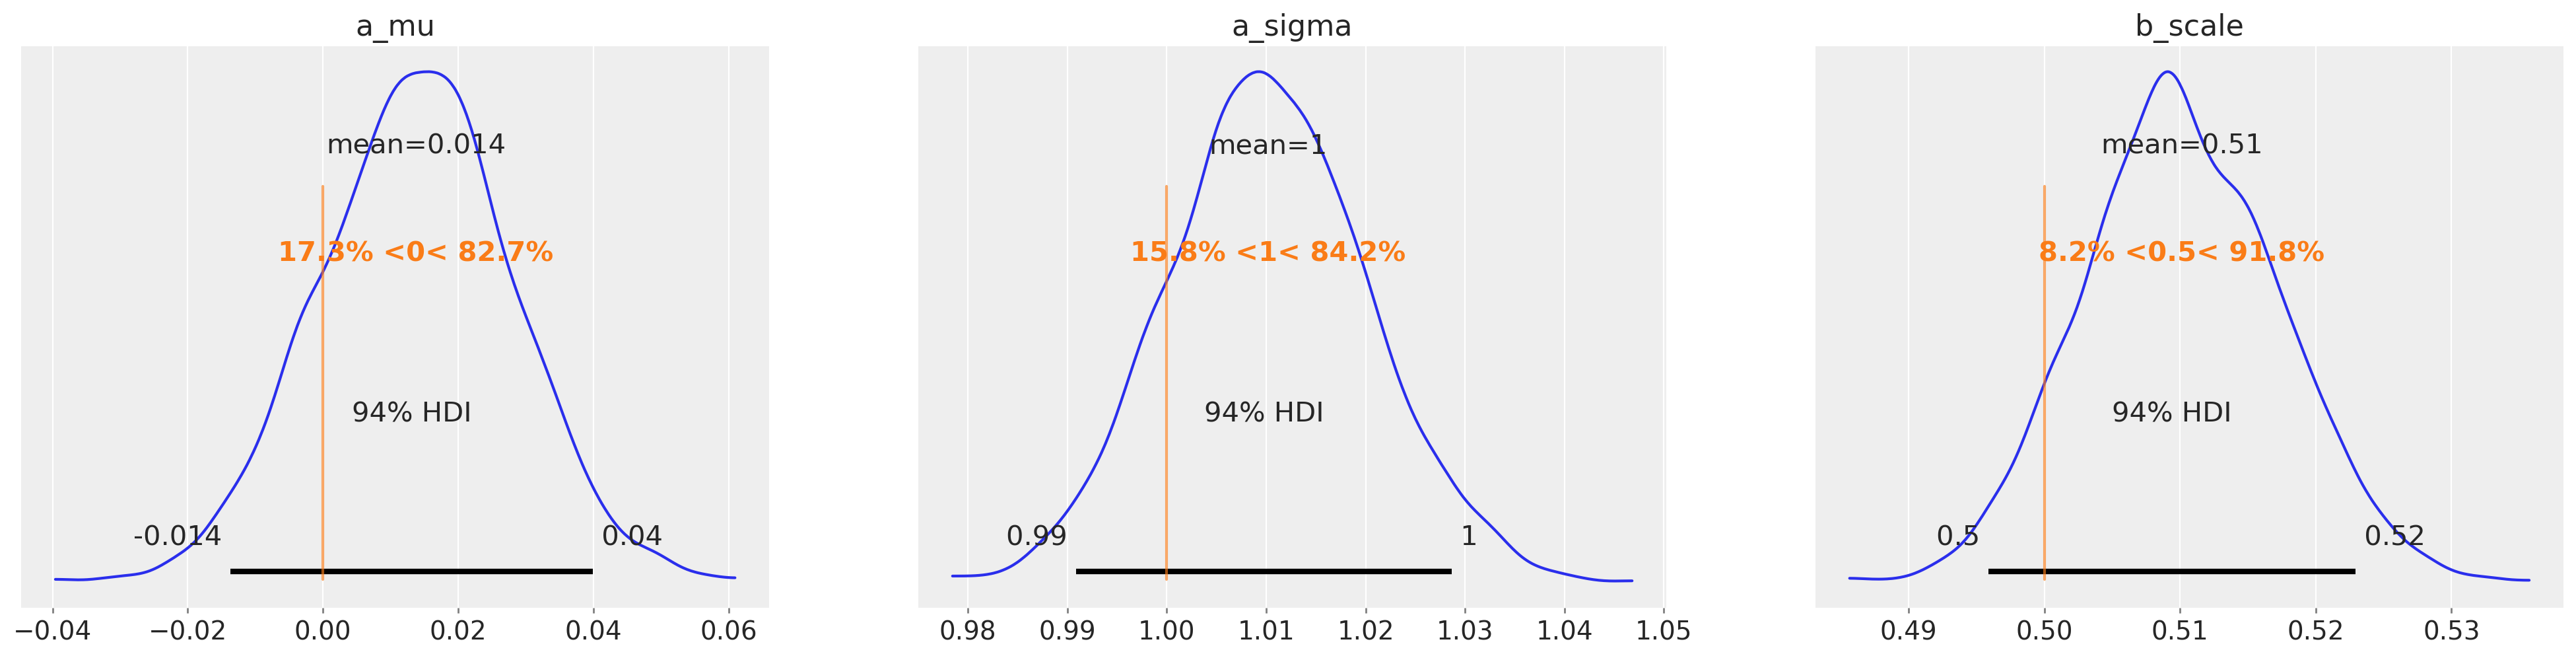

In [10]:
with marginal_model:
    marginal_idata = pm.sample(random_seed=rng)

az.plot_posterior(
    marginal_idata, var_names=["a_mu", "a_sigma", "b_scale"], ref_val=[0, 1.0, 1 / 2.0]
);

以下のコピュラ モデルでは、共分散パラメーターに対して事前分布を設定していることがわかります。
このパラメータの事後分布は、多変量正規空間のデータによって制約されます。
しかし、そのためには、観測空間の観測値 ```[a, b]``` を多変量正規空間に変換し、それを ```data``` に保存する必要があります。

点推定の使用について: 以下のコードでわかるように、ステップ 1 の完全な事後推定ではなく、ステップ 1 の点推定を使用することを選択しました。これは、渡すときのテンソル形状処理の複雑さのために選択した単純化です。 事後分布では分布のパラメータとして使用されます。

ただし、ノートブックのレビュー中に、[@OriolAbril](https://github.com/OriolAbril) (PyMC Examples リポジトリの管理者の 1 人) は、点推定を使用して分布に基づいて評価されたデータ ポイントの logcdf を累乗しても、必ずしも同じ値が返されるわけではないことを正しく指摘しました。 多くの可能な分布 (完全事後分布から構築) の下で評価されたデータ ポイントの logcdf を累乗する期待値。 ノートブックのタイムリーな進捗を確保するために、コードを現状のまま表示することにしましたが、将来の読者が後でノートブックを更新できるようにこのメモを残し、サンプルを修正して将来の読者が貢献する機会も提供します。 この点。

In [11]:
def transform_data(marginal_idata):
    # point estimates
    a_mu = marginal_idata.posterior["a_mu"].mean().item()
    a_sigma = marginal_idata.posterior["a_sigma"].mean().item()
    b_scale = marginal_idata.posterior["b_scale"].mean().item()
    # transformations from observation space -> uniform space
    __a = pt.exp(pm.logcdf(pm.Normal.dist(mu=a_mu, sigma=a_sigma), a))
    __b = pt.exp(pm.logcdf(pm.Exponential.dist(lam=1 / b_scale), b))
    # uniform space -> multivariate normal space
    _a = pm.math.probit(__a)
    _b = pm.math.probit(__b)
    # join into an Nx2 matrix
    data = pt.math.stack([_a, _b], axis=1).eval()
    return data, a_mu, a_sigma, b_scale


data, a_mu, a_sigma, b_scale = transform_data(marginal_idata)

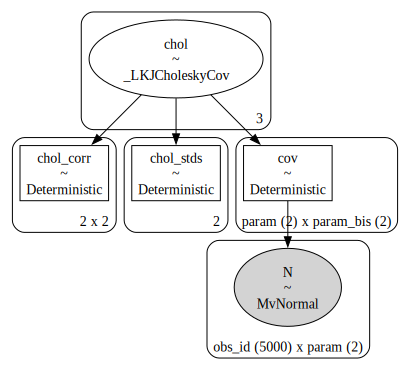

In [12]:
coords.update({"param": ["a", "b"], "param_bis": ["a", "b"]})
with pm.Model(coords=coords) as copula_model:
    # Prior on covariance of the multivariate normal
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    # Likelihood function
    pm.MvNormal("N", mu=0.0, cov=cov, observed=data, dims=("obs_id", "param"))

pm.model_graph.model_to_graphviz(copula_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [chol]


Output()

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pytensor\compile\function\types.py:970: RuntimeWarning: 
invalid value encountered in accumulate
  self.vm()

Output()

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


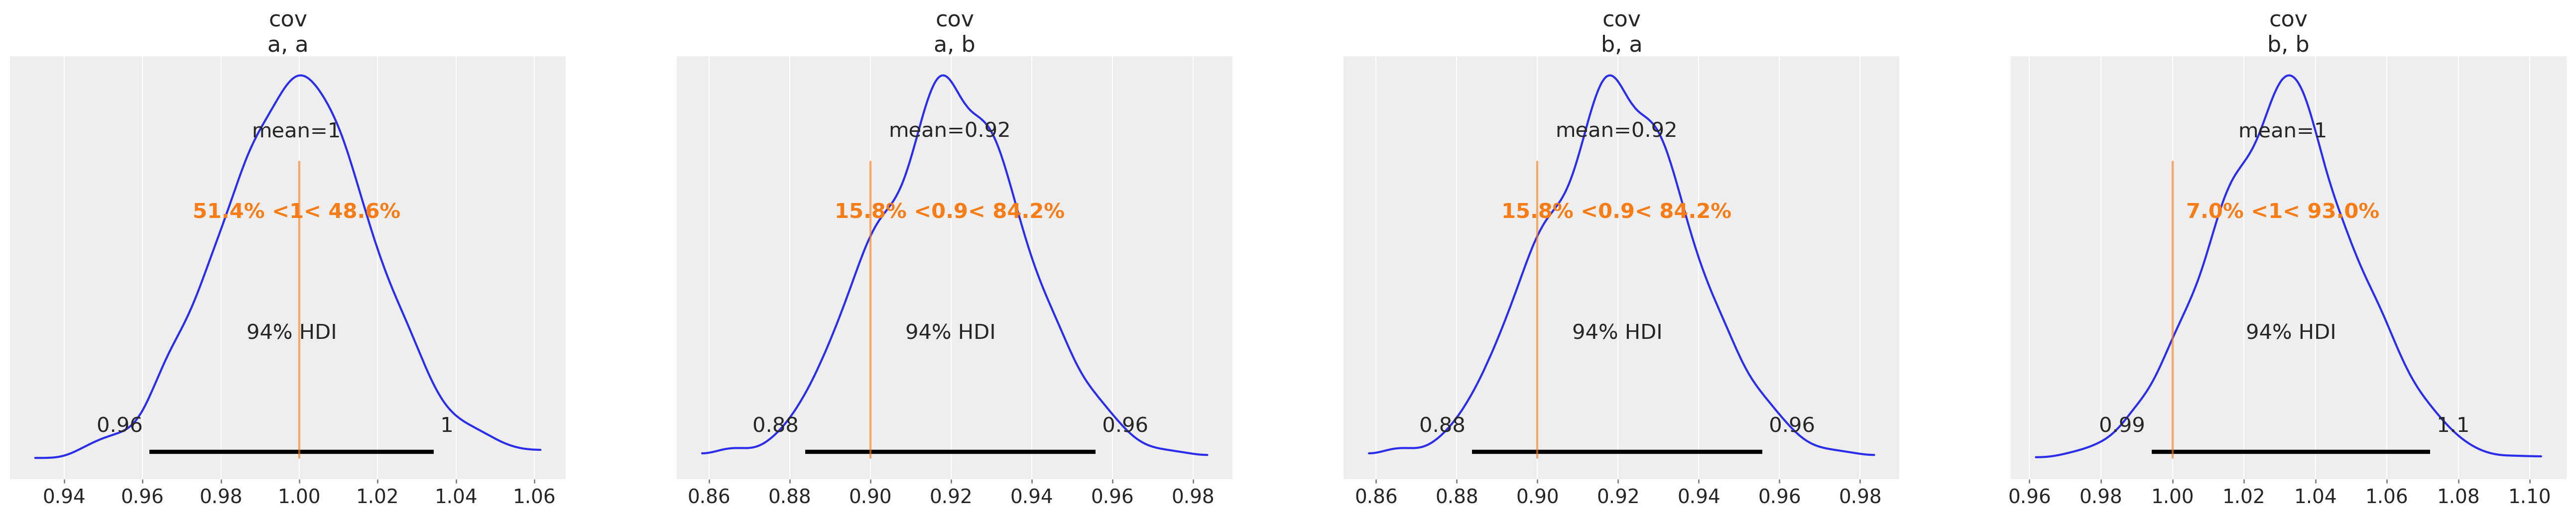

In [13]:
with copula_model:
    copula_idata = pm.sample(random_seed=rng, tune=2000, cores=1)

az.plot_posterior(copula_idata, var_names=["cov"], ref_val=[1.0, θ["rho"], θ["rho"], 1.0]);

以下のセクションでは、$P(a, b)$ のパラメトリック記述からサンプリングするためにこの情報を使用します。

## Comparing inferences against the true data
最後に、推論 (赤) が元の観察データ (黒) と一致するかどうかを視覚的に確認できます。

In [14]:
# data munging to extract covariance estimates from copula_idata in useful shape
d = {k: v.values.reshape((-1, *v.shape[2:])) for k, v in copula_idata.posterior[["cov"]].items()}

# generate (a, b) samples
ab = np.vstack([multivariate_normal([0, 0], cov).rvs() for cov in d["cov"]])

# transform to uniform space
uniform_a = norm().cdf(ab[:, 0])
uniform_b = norm().cdf(ab[:, 1])

# transform to observation space
# estimated marginal parameters a_mu, a_sigma, b_scale are point estimates from marginal estimation.
ppc_a = norm(loc=a_mu, scale=a_sigma).ppf(uniform_a)
ppc_b = expon(scale=b_scale).ppf(uniform_b)

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\kdeplot.py:166: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(x_x, y_y, density, **contour_kwargs)


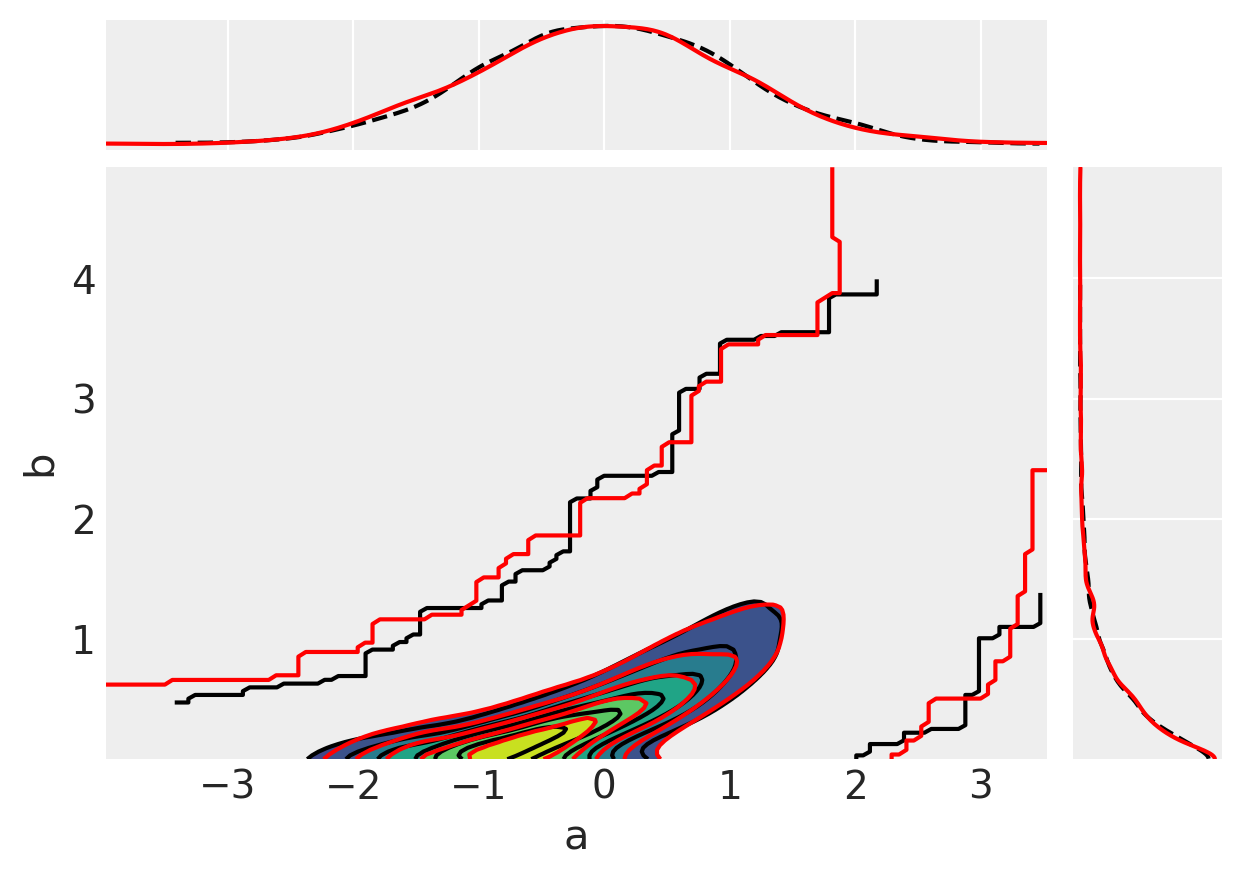

In [15]:
# plot data in black
ax = az.plot_pair(
    {"a": a, "b": b},
    marginals=True,
    # kind=["kde", "scatter"],
    kind="kde",
    scatter_kwargs={"alpha": 0.1},
    kde_kwargs=dict(
        contour_kwargs=dict(colors="k", linestyles="--"), contourf_kwargs=dict(alpha=0)
    ),
    marginal_kwargs=dict(color="k", plot_kwargs=dict(ls="--")),
)

# plot inferences in red
axs = az.plot_pair(
    {"a": ppc_a, "b": ppc_b},
    marginals=True,
    # kind=["kde", "scatter"],
    kind="kde",
    scatter_kwargs={"alpha": 0.01},
    kde_kwargs=dict(contour_kwargs=dict(colors="r", linestyles="-"), contourf_kwargs=dict(alpha=0)),
    marginal_kwargs=dict(color="r"),
    ax=ax,
);

## Acknowledgements
We would like to acknowledge [Jonathan Sedar](https://github.com/jonsedar), [Junpeng Lao](https://github.com/junpenglao), and [Oriol Abril](https://github.com/OriolAbril) for useful advice during the development of this notebook.

## Authors
Authored by [Eric Ma](https://www.pymc-labs.com/team) & [Benjamin T. Vincent](https://github.com/drbenvincent) in November, 2023 ([pymc-examples#257](https://github.com/pymc-devs/pymc-examples/pull/257)).

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Wed Apr 10 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.20.0
xarray  : 2024.3.0

arviz     : 0.18.0
seaborn   : 0.13.2
matplotlib: 3.8.4
pytensor  : 2.20.0
numpy     : 1.26.4
pymc      : 5.13.0

Watermark: 2.4.3



## License notice
All the notebooks in this example gallery are provided under the [MIT License](https://github.com/pymc-devs/pymc-examples/blob/main/LICENSE) which allows modification, and redistribution for any use provided the copyright and license notices are preserved.

## Citing PyMC examples
To cite this notebook, use the DOI provided by Zenodo for the pymc-examples repository.

Important

Many notebooks are adapted from other sources: blogs, books… In such cases you should cite the original source as well.

Also remember to cite the relevant libraries used by your code.

Here is an citation template in bibtex:

```py
@incollection{citekey,
  author    = "<notebook authors, see above>",
  title     = "<notebook title>",
  editor    = "PyMC Team",
  booktitle = "PyMC examples",
  doi       = "10.5281/zenodo.5654871"
}
```
which once rendered could look like:

Benjamin T. Vincent , Eric Ma . "Bayesian copula estimation: Describing correlated joint distributions". In: PyMC Examples. Ed. by PyMC Team. DOI: [10.5281/zenodo.5654871](https://doi.org/10.5281/zenodo.5654871)